In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input/sign-language-mnist'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# Load the data from folders and prepare training and test data
def get_data(folder_path) :
    with open(folder_path) as folder_csv :
        data = folder_csv.read().split('\n')[1:-1] # first row has the feature names and last row picks empty line
        images, labels = [], []
        for img in data :
            temp = img.split(',')
            if int(temp[0]) > 9 :
                labels.append(int(temp[0])-1)
            else : 
                labels.append(int(temp[0]))
            images.append(np.reshape(temp[1:], (28,28)).astype(float))
        return np.array(images), np.array(labels)

train_path = '/kaggle/input/sign-language-mnist/sign_mnist_train/sign_mnist_train.csv'
test_path = '/kaggle/input/sign-language-mnist/sign_mnist_test/sign_mnist_test.csv'
train_imgs, train_labels = get_data(train_path)
test_imgs, test_labels = get_data(test_path)

num_labels = len(set(test_labels))
print(len(set(test_labels)), len(set(train_labels)))

24 24


In [3]:
print(set(test_labels), set(train_labels))

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23} {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23}


In [4]:
# Data Generators with Image Augmentation on Train Data
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    horizontal_flip=True,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1/255.0)

# Add Extra dimensions to the get the black and white images
train_imgs = np.expand_dims(train_imgs, axis=3)
test_imgs = np.expand_dims(test_imgs, axis=3)

In [5]:
print(train_imgs.shape, test_imgs.shape)

(27455, 28, 28, 1) (7172, 28, 28, 1)


In [6]:
# Model Structure and compile
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_labels, activation='softmax')
])

model.summary()

# Compile the model (Use Sparse Categorical as high number of labels)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               819712    
_________________________________________________________________
dense_1 (Dense)              (None, 24)                1


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=false
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_PATTERN='hyper,hyper'
   KMP_REDUCTION_BARRIER='1,1'
  

In [7]:
# Callback implementation for 95% accuracy
# class myCallback(tf.keras.callbacks.Callback) :
#     def on_epoch_end(self, logs={}, epoch) :
#         if logs.get('accuracy') > 0.95 :
#             print("Yaay, got more than 95% accuracy. Enough for now")
#             self.model.stop_training = True

# callbacks = myCallback()

# Fit the data into the model using the Data Generators created 
history = model.fit(
    train_datagen.flow(train_imgs, train_labels),
    validation_data = validation_datagen.flow(test_imgs, test_labels),
    epochs = 25
)

2022-01-23 11:23:57.222430: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25
858/858 [==============================] - 19s 21ms/step - loss: 2.5371 - accuracy: 0.2194 - val_loss: 1.5215 - val_accuracy: 0.4502
Epoch 2/25
858/858 [==============================] - 18s 21ms/step - loss: 1.6139 - accuracy: 0.4729 - val_loss: 1.0187 - val_accuracy: 0.6405
Epoch 3/25
858/858 [==============================] - 19s 22ms/step - loss: 1.1966 - accuracy: 0.6084 - val_loss: 0.7566 - val_accuracy: 0.7179
Epoch 4/25
858/858 [==============================] - 18s 21ms/step - loss: 0.9686 - accuracy: 0.6799 - val_loss: 0.4785 - val_accuracy: 0.8427
Epoch 5/25
858/858 [==============================] - 18s 21ms/step - loss: 0.8136 - accuracy: 0.7297 - val_loss: 0.3854 - val_accuracy: 0.8805
Epoch 6/25
858/858 [==============================] - 18s 22ms/step - loss: 0.6960 - accuracy: 0.7702 - val_loss: 0.2988 - val_accuracy: 0.8925
Epoch 7/25
858/858 [==============================] - 18s 21ms/step - loss: 0.6166 - accuracy: 0.7952 - val_loss: 0.3146 - val_accuracy:

In [8]:
# Model evaluates the test data
model.evaluate(test_imgs, test_labels, verbose=0)

[71.73463439941406, 0.8678193092346191]

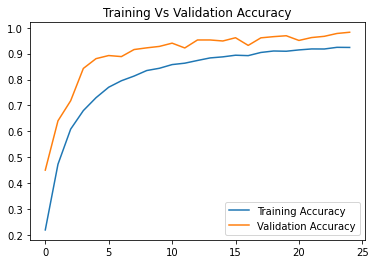

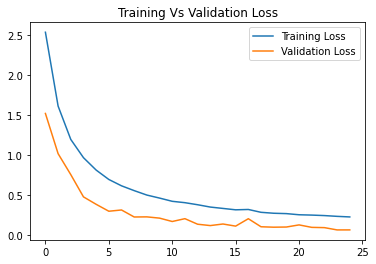

In [9]:
# Compare the Training and Validation Accuracy, Loss
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_loss))

plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title("Training Vs Validation Accuracy")
plt.legend()
plt.figure()

plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title("Training Vs Validation Loss")
plt.legend()

plt.show()

# figure, axis = plt.subplots(2,1)

# axis[0].plot(epochs, train_acc, label='Training Accuracy')
# axis[0].plot(epochs, val_acc, label='Validation Accuracy')
# axis[0].title("Training Vs Validation Accuracy")
# axis[0].legend()

# axis[1].plot(epochs, train_loss, label='Training Loss')
# axis[1].plot(epochs, val_loss, label='Validation Loss')
# axis[1].title("Training Vs Validation Loss")
# axis[1].legend()

# plt.show()
